In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


n_variables=5
n_timesteps=1000

def save_to_excel(df, file_path):
    # Ensure the file path ends with .xlsx
    if not file_path.endswith('.xlsx'):
        file_path += '.xlsx'
    
    if os.path.exists(file_path):
        try:
            existing_df = pd.read_excel(file_path)
            combined_df = pd.concat([existing_df, df], ignore_index=True)
        except Exception as e:
            print(f"Error reading existing file: {e}")
            print("Creating a new file instead.")
            combined_df = df
    else:
        combined_df = df
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='w') as writer:
        combined_df.to_excel(writer, index=False)

    print(f"Data successfully saved to {file_path}")

def create_seasonality_series(n_variables=n_variables, n_timesteps=n_timesteps, seasonality_period=50, noise_level=0.1, save_data=False):
        
    # Create time vector
    time = np.arange(n_timesteps)

    # Generate synthetic multivariate time series data
    data = np.zeros((n_timesteps, n_variables))
    for i in range(n_variables):
        # Add high seasonality with different phases and amplitudes
        amplitude = np.random.uniform(0.5, 1.5)
        phase = np.random.uniform(0, 2 * np.pi)
        data[:, i] = amplitude * np.sin(2 * np.pi * time / seasonality_period + phase)

        # Add some noise
        data[:, i] += np.random.normal(0, noise_level, n_timesteps)

    # Convert to a pandas DataFrame for visualization and manipulation
    columns = [f"Variable_{i+1}" for i in range(n_variables)]
    synthetic_data = pd.DataFrame(data, columns=columns)

    # Plot the generated time series data
    synthetic_data.plot(figsize=(12, 6))
    plt.title("Synthetic Multivariate Time Series with High Seasonality")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid()
    plt.show()

    if save_data:
        directory = '../multiTS/NFT/data/seasonality/'
        file_path = os.path.join(directory, 'seasonality.pkl')
        os.makedirs(directory, exist_ok=True)
        synthetic_data.to_pickle(file_path)

def process_component_info(seasonality_trend_info, series_name):
    component_info = pd.DataFrame(seasonality_trend_info)
    component_info['Series_Name'] = series_name

    averages = component_info.select_dtypes(include='number').mean()
    averages_row = {col: averages[col] if col in averages.index else None for col in component_info.columns}
    averages_row['Series_Name'] = series_name
    averages_row['Series'] = 'Average'
    averages_row['Seasonality_Precetage'] = averages_row['Seasonality_Dominance'] / (averages_row['Seasonality_Dominance']  + averages_row['Trend_Dominance'])
    averages_df = pd.DataFrame([averages_row])

    component_info = pd.concat([component_info, averages_df], ignore_index=True)

    cols = ['Series_Name'] + [col for col in component_info.columns if col != 'Series_Name']
    component_info = component_info[cols]

    print("Averaged Component Info:")
    print(averages_df[cols].head(6))

    return component_info, averages_df[cols]

def create_time_series(
    num_series, 
    num_points,
    trend_amplitude=0.5, 
    noise_level=1, 
    seasonal_amplitude=1, # (0.5, 1.5)
    save_data=False,
    series_name=None,
    compute_components=True  # parameter to compute seasonality and trend proportions
    ):
    time = np.arange(num_points)
    data = {}
    seasonality_trend_info = []

    for i in range(num_series):
        trend = trend_amplitude * (time / num_points)
        
        phase = np.random.uniform(0, 2 * np.pi)
        seasonal = (seasonal_amplitude * (i+1)) * np.sin(2 * np.pi * time / (50 + i * 5) + i * phase)
    
        noise = np.random.normal(0, noise_level, num_points)
        
        series = trend + seasonal + noise
        data[f"Series_{i+1}"] = series
        
        if compute_components:
            total_variance = np.var(series)
            seasonal_variance = np.var(seasonal)
            trend_variance = np.var(trend)
            noise_variance = np.var(noise)
        

            seasonality_ratio = seasonal_variance / total_variance
            trend_ratio = trend_variance / total_variance
            trend_to_seasonality_ratio = trend_variance / seasonal_variance if seasonal_variance > 0 else np.inf
            seasonality_to_trend_ratio = seasonal_variance / trend_variance if trend_variance > 0 else np.inf
            noise_ratio = noise_variance / total_variance
            
            trend_dominance = max(0, 1 - (noise_variance / (noise_variance + trend_variance)))
            seasonality_dominance = max(0, 1 - (noise_variance / (noise_variance + seasonal_variance)))

            seasonality_trend_info.append({
                'Series': f"Series_{i+1}",
                'Seasonality_Dominance': seasonality_dominance,
                'Trend_Dominance': trend_dominance,
                'Seasonality_Ratio': seasonality_ratio,
                'Trend_Ratio': trend_ratio,
                'Trend_to_Seasonality_Ratio': trend_to_seasonality_ratio,
                'Seasonality_to_Trend_Ratio': seasonality_to_trend_ratio,
                'Noise_Ratio': noise_ratio
            })

    synthetic_data = pd.DataFrame(data, index=time)
    # synthetic_data.plot(figsize=(10, 6), title="Synthetic Multivariate Time Series")
    # plt.xlabel("Time")
    # plt.ylabel("Value")
    # plt.show()
    
    component_info = process_component_info(seasonality_trend_info, series_name=series_name)

    
    if save_data:
        directory = f'/home/../multiTS/NFT/data/{series_name}/'
        file_path = os.path.join(directory, f'{series_name}.pkl')
        os.makedirs(directory, exist_ok=True)
        synthetic_data.to_pickle(file_path)
        
        save_to_excel(component_info, '/home/../multiTS/NFT/models/tests/analyse_data/data_components.xlsx')

  
# for seasonal_amplitude in [4, 5, 6, 7, 8, 9, 10]:
#     for trend_amplitude in [0.50]:
#         # create_time_series(
#         #     num_series=n_variables, 
#         #     num_points=n_timesteps,
#         #     trend_amplitude=trend_amplitude, 
#         #     noise_level=0.1, 
#         #     seasonal_amplitude=seasonal_amplitude,
#         #     save_data=True,
#         #     series_name=f'seasonal_{seasonal_amplitude}_trend_{trend_amplitude}'
#         #     )
         

In [ ]:
def get_components(y):

    # Step 2: Apply Fast Fourier Transform (FFT)
    n = len(y)  # Length of the signal
    fft_vals = np.fft.fft(y)  # FFT
    frequencies = np.fft.fftfreq(n)  # Frequency bins

    # Step 3: Identify dominant frequencies (filtering)
    # Sort by the magnitude of the FFT values and retain top frequencies
    magnitude = np.abs(fft_vals)
    threshold = 0.05 * max(magnitude)  # Keep frequencies with > 5% of max amplitude
    filtered_fft_vals = fft_vals.copy()
    filtered_fft_vals[magnitude < threshold] = 0  # Zero out low-amplitude components

    # Step 4: Reconstruct the seasonality using Inverse FFT (IFFT)
    seasonality = np.fft.ifft(filtered_fft_vals).real
    
    # Step 5: Filter out high frequencies (low-pass filter)
    # Define a cutoff frequency: retain only the low frequencies
    cutoff = 0.05  # Adjust this value based on your data (0 < cutoff < 1)
    filtered_fft_vals = fft_vals.copy()
    filtered_fft_vals[np.abs(frequencies) > cutoff] = 0  # Zero out high-frequency components

    # Step 4: Reconstruct the trend using Inverse FFT (IFFT)
    trend = np.fft.ifft(filtered_fft_vals).real
    
    noise = y - seasonality - trend
    
    return seasonality, trend, noise
 
def plot_componentes(y, seasonality, trend, noise):
    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Original Series', color='blue')
    plt.plot(seasonality, label='Extracted Seasonality', color='red')
    plt.plot(trend, label='Extracted Trend', color='orange')
    plt.plot(noise, label='Extracted Noise', color='green')
    plt.title('Components Extraction using Fourier Transform')
    plt.legend()
    plt.show()
 
def calculate_components_dominance(data, data_name, save_Excel=False):
    seasonality_trend_info = []
    for column in data.columns:
        y = data[column]
            
        seasonal, trend, noise = get_components(y)

        total_variance = y.var()
        seasonal_variance = seasonal.var()
        trend_variance = trend.var()
        noise_variance = noise.var()

        seasonality_dominance = max(0, 1 - (noise_variance / (noise_variance + seasonal_variance)))
        trend_dominance = max(0, 1 - (noise_variance / (noise_variance + trend_variance)))
        seasonality_precetage = seasonality_dominance / (seasonality_dominance + trend_dominance) if (seasonality_dominance + trend_dominance) != 0 else 0
        
        print(seasonality_dominance, trend_dominance, seasonality_precetage)
        
        seasonality_trend_info.append({
            'Series': column,
            'Seasonality_Dominance': seasonality_dominance,
            'Trend_Dominance': trend_dominance,
            'Seasonality_Precetage': seasonality_precetage,
            'total_variance': total_variance,
            'seasonal_variance': seasonal_variance,
            'trend_variance': trend_variance,
            'noise_variance': noise_variance,
            })
        
    component_info, averages_df = process_component_info(seasonality_trend_info, series_name=data_name)
    if save_Excel:
        save_to_excel(averages_df, f'/home/../multiTS/NFT/models/tests/analyse_data/real_data_components.xlsx')

    return component_info, averages_df

# pkl_dir = "/home/../multiTS/NFT/data/ecg/pkl_files/"
# for pkl_file in os.listdir(pkl_dir):
#     if pkl_file.endswith(".pkl"):  # Check if the file is a .pkl file
#         file_path = os.path.join(pkl_dir, pkl_file)  # Full path to the file
#         data = pd.read_pickle(file_path)
#         component_info, averages_df = calculate_components_dominance(data, pkl_file[:-4], save_Excel=True)


# pkl_dir = "/home/../multiTS/NFT/data/eeg_single/"
# for pkl_file in os.listdir(pkl_dir):
#     if pkl_file.endswith(".pkl"):  # Check if the file is a .pkl file
#         file_path = os.path.join(pkl_dir, pkl_file)  # Full path to the file
#         data = pd.read_pickle(file_path)
#         component_info, averages_df = calculate_components_dominance(data, pkl_file[:-4], save_Excel=True)
        
# for dataset in ['electricity', 'exchange', 'illness', 'traffic']:
#     data = pd.read_pickle(f'/home/../multiTS/NFT/data/{dataset}/{dataset}_no_date.pkl')
#     component_info, averages_df = calculate_components_dominance(data, dataset, save_Excel=True)


# data = pd.read_pickle('/home/../multiTS/NFT/data/electricity/mini_elctricity.pkl')
# component_info, averages_df = calculate_components_dominance(data, dataset, save_Excel=True)


data = pd.read_pickle('/home/../multiTS/NFT/data/air_quality/air_quality.pkl')
component_info, averages_df = calculate_components_dominance(data, 'air_quality', save_Excel=True)

# for n in ['AE000041196', 'AEM00041194', 'AEM00041217']:
#     data = pd.read_pickle(f'/home/../multiTS/NFT/data/noaa/noaa_ghcn/noaa_pkl/{n}.pkl')
#     component_info, averages_df = calculate_components_dominance(data, n, save_Excel=True)

# pkl_dir = "/home/../multiTS/NFT/data/noaa/noaa_ghcn/years/embedded/AEM00041217/"
# for pkl_file in os.listdir(pkl_dir):
#     if pkl_file.endswith(".pkl"):  # Check if the file is a .pkl file
#         file_path = os.path.join(pkl_dir, pkl_file)  # Full path to the file
#         data = pd.read_pickle(file_path)
#         component_info, averages_df = calculate_components_dominance(data, pkl_file[:-4], save_Excel=True)
        
# csv_dir = '/home/../multiTS/NFT/data/chorales/chorales_csvs'
# for csv_file in os.listdir(csv_dir):
#     if csv_file.endswith(".csv"):  # Check if the file is a .pkl file
#         file_path = os.path.join(csv_dir, csv_file)  # Full path to the file
#         data = pd.read_csv(file_path)
#         component_info, averages_df = calculate_components_dominance(data, csv_file[:-4], save_Excel=True)

In [ ]:
pkl_path = '/home/../multiTS/NFT/data/electricity/electricity_no_date.pkl'
d = pd.read_pickle(pkl_path)
column_indices_to_extract = [20, 44, 92, 64, 58, 71, 47, 13, 21, 22, 3, 5, 10, 16, 7, 15, 2, 69, 4, 6, 1, 29, 0, 8, 25, 55, 122, 125, 131, 99, 84, 9, 50, 113, 117, 118]
mini_elctricity = d.iloc[:, column_indices_to_extract]
mini_elctricity.to_pickle('/home/../multiTS/NFT/data/electricity/mini_elctricity.pkl')




In [ ]:
print(d.columns)
d['0', '1']

In [ ]:
# import os
# import pandas as pd

# csv_dir = '/home/../multiTS/NFT/data/chorales/chorales_csvs'

# data_names = []
# data_lengths = []

# for csv_file in os.listdir(csv_dir):
#     if csv_file.endswith(".csv"):  # Check if the file is a .csv file
#         file_path = os.path.join(csv_dir, csv_file)  # Full path to the file
#         data = pd.read_csv(file_path)
#         data_names.append(csv_file[:-4])  # Remove .csv extension
#         data_lengths.append(len(data))  # Get length of the data

# output_df = pd.DataFrame({
#     'Data Name': data_names,
#     'Data Length': data_lengths
# })

# output_excel_path = '/home/../multiTS/NFT/data/chorales/chorales_data_summary.xlsx'
# output_df.to_excel(output_excel_path, index=False)

# output_excel_path


In [1]:
import numpy as np

# Data points
x = np.array([0.44, 0.46, 0.48, 0.50, 0.51, 0.60])
y = np.array([1.82, 4.16, 12.9, 6.06, 9.99, 5.76])

# Calculate linear regression
m, b = np.polyfit(x, y, 1)  # 1 indicates linear fit
print(f"Slope (m): {m}, Intercept (b): {b}")


Slope (m): 13.397449521785292, Intercept (b): 0.10527098831033062


In [ ]:

# Data points
x = np.array([0.44, 0.46, 0.48, 0.50, 0.51, 0.60])
y = np.array([1.82, 4.16, 12.9, 6.06, 9.99, 5.76])

# Calculate linear regression
m, b = np.polyfit(x, y, 1)  # 1 indicates linear fit
print(f"Slope (m): {m}, Intercept (b): {b}")


In [ ]:
import numpy as np
import pandas as pd
import os 

def estimate_dominant_cycle_multivariate(df, sampling_rate=1, min_freq=1/100, max_freq=0.5, plot=False):
    """
    Estimate average dominant cycle length across all variables using FFT,
    excluding near-zero or unrealistic frequencies.
    
    Parameters:
        df (pd.DataFrame): Multivariate time series (timesteps x variables)
        sampling_rate (float): Sampling rate (e.g., 1 for unit steps)
        min_freq (float): Minimum allowed frequency (default = 1/100)
        max_freq (float): Max allowed frequency (Nyquist = 0.5 if sampling_rate=1)
        plot (bool): Show plots (default = False)
        
    Returns:
        float: Average cycle length across valid variables
    """
    total_cycle = 0
    valid_count = 0

    for var in df.columns:
        series = df[var].values
        n = len(series)
        series_detrended = series - np.mean(series)

        fft_vals = np.fft.fft(series_detrended)
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        positive_freqs = freqs[:n//2]
        magnitudes = np.abs(fft_vals[:n//2])

        # Filter out unwanted frequencies
        valid_mask = (positive_freqs >= min_freq) & (positive_freqs <= max_freq)
        if not np.any(valid_mask):
            continue

        valid_freqs = positive_freqs[valid_mask]
        valid_mags = magnitudes[valid_mask]

        peak_idx = np.argmax(valid_mags)
        dominant_freq = valid_freqs[peak_idx]

        if dominant_freq > 0:
            cycle_length = 1 / dominant_freq
            total_cycle += cycle_length
            valid_count += 1

    return total_cycle / valid_count if valid_count > 0 else None

# Example usage across datasets
for dataset in [ 'exchange','electricity', 'traffic']:
    df = pd.read_pickle(f'/home/../multiTS/NFT/data/{dataset}/{dataset}_no_date.pkl')
    print(f"\n=== {dataset} ===")
    avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
    if avg_cycle:
        print(f"Average estimated cycle length: {avg_cycle:.2f}")
    else:
        print("No valid dominant cycles detected.")
        

df = pd.read_csv(f'/home/../multiTS/NFT/data/noaa/AEM00041217.csv')
print(f"\n=== noaa ===")
avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
if avg_cycle:
    print(f"Average estimated cycle length: {avg_cycle:.2f}")
else:
    print("No valid dominant cycles detected.")


df = pd.read_pickle(f'/home/../multiTS/NFT/data/ettm1/ETTm1_no_date.pkl')
print(f"\n=== ettm1 ===")
avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
if avg_cycle:
    print(f"Average estimated cycle length: {avg_cycle:.2f}")
else:
    print("No valid dominant cycles detected.")



pkl_dir = "/home/../multiTS/NFT/data/ecg_single/pkl_files/"
c = 0
for pkl_file in os.listdir(pkl_dir):
    if pkl_file.endswith(".pkl"):  # Check if the file is a .pkl file
        file_path = os.path.join(pkl_dir, pkl_file)  # Full path to the file
        df = pd.read_pickle(file_path)
        avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
        c += avg_cycle
        # print(f"\n=== {pkl_file} ===")
        # if avg_cycle:
        #     print(f"Average estimated cycle length: {avg_cycle:.2f}")
        # else:
        #     print("No valid dominant cycles detected.")
print(f"\n=== ECG ===")
print(f"Average estimated cycle length: {c/4:.2f}")


pkl_dir = "/home/../multiTS/NFT/data/eeg_single/"
c = 0
for pkl_file in os.listdir(pkl_dir):
    if pkl_file.endswith(".pkl"):  # Check if the file is a .pkl file
        file_path = os.path.join(pkl_dir, pkl_file)  # Full path to the file
        df = pd.read_pickle(file_path)
        avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
        c += avg_cycle
        # print(f"\n=== {pkl_file} ===")
        # if avg_cycle:
        #     print(f"Average estimated cycle length: {avg_cycle:.2f}")
        # else:
        #     print("No valid dominant cycles detected.")
print(f"\n=== EEG ===")
print(f"Average estimated cycle length: {c/2:.2f}")


c = 0
n = 0
csv_dir = '/home/../multiTS/NFT/data/chorales/chorales_csvs'
for csv_file in os.listdir(csv_dir):
    if csv_file.endswith(".csv"):  # Check if the file is a .pkl file
        file_path = os.path.join(csv_dir, csv_file)  # Full path to the file
        df = pd.read_csv(file_path)
        avg_cycle = estimate_dominant_cycle_multivariate(df, sampling_rate=1, plot=False)
        c += avg_cycle
        n += 1
print(f"\n=== Chorales ===")
print(f"Average estimated cycle length: {c/n:.2f}")



=== exchange ===
Average estimated cycle length: 87.50

=== electricity ===


Average estimated cycle length: 23.95

=== traffic ===
Average estimated cycle length: 24.00

=== noaa ===
Average estimated cycle length: 70.14

=== ettm1 ===
Average estimated cycle length: 89.12

=== ECG ===
Average estimated cycle length: 69.95

=== EEG ===
Average estimated cycle length: 36.60

=== Chorales ===
Average estimated cycle length: 30.57


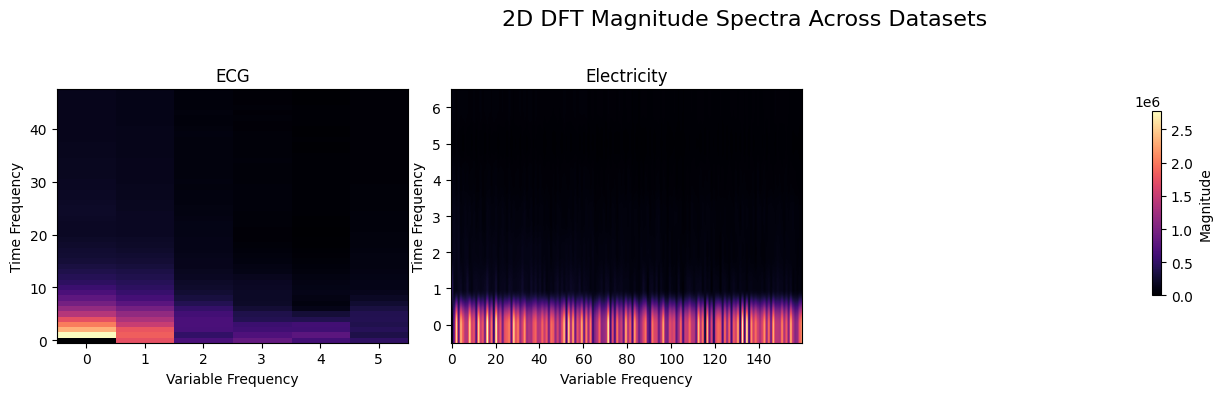

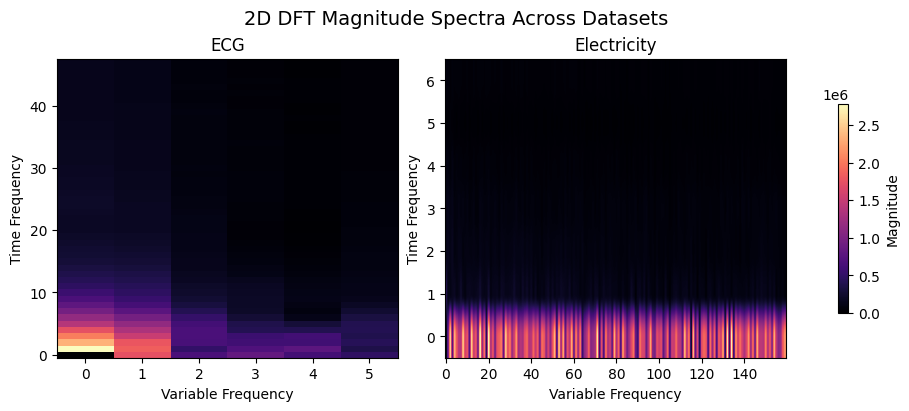

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_2d_dft_magnitude(timeseries):
    """Compute 2D DFT magnitude for a time × variable matrix."""
    X = timeseries - np.mean(timeseries)
    fft2d = np.fft.fft2(X)
    magnitude = np.abs(fft2d)
    return magnitude[:X.shape[0]//2, :X.shape[1]//2]  # low-frequency quadrant

# Dataset loading instructions
datasets = [
    ("ECG", pd.read_pickle('/home/../multiTS/NFT/data/ecg_single/pkl_files/E00003.pkl').iloc[:96].values),
    # ("EEG", pd.read_pickle('/home/../multiTS/NFT/data/eeg_single/test_1.pkl').iloc[:15].values),
    # ("ETTm1", pd.read_pickle('/home/../multiTS/NFT/data/ettm1/ETTm1_no_date.pkl').iloc[:15].values),
    ("Electricity", pd.read_pickle('/home/../multiTS/NFT/data/electricity/electricity_no_date.pkl').iloc[:15].values),
    # ("Exchange", pd.read_pickle('/home/../multiTS/NFT/data/exchange/exchange_no_date.pkl').iloc[:15].values),
    # ("Traffic", pd.read_pickle('/home/../multiTS/NFT/data/traffic/traffic_no_date.pkl').iloc[:5].values),
    # ("Weather", pd.read_csv('/home/../multiTS/NFT/data/noaa/AEM00041217.csv').iloc[:96].values),
    
]

# Plot
n_cols = 3
n_rows = int(np.ceil(len(datasets) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, (title, data) in enumerate(datasets):
    mag = compute_2d_dft_magnitude(data)
    im = axes[i].imshow(mag, aspect='auto', origin='lower', cmap='magma')
    axes[i].set_title(title)
    axes[i].set_xlabel('Variable Frequency')
    axes[i].set_ylabel('Time Frequency')

# Remove empty subplots if any
for j in range(len(datasets), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('2D DFT Magnitude Spectra Across Datasets', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.6, label='Magnitude')

plt.show()


# Plot config
n_cols = len(datasets)
fig, axes = plt.subplots(1, n_cols, figsize=(4.5 * n_cols, 4), constrained_layout=True)

if n_cols == 1:
    axes = [axes]

for ax, (title, data) in zip(axes, datasets):
    mag = compute_2d_dft_magnitude(data)
    im = ax.imshow(mag, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Variable Frequency')
    ax.set_ylabel('Time Frequency')

# Shared colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.7, label='Magnitude')

plt.suptitle('2D DFT Magnitude Spectra Across Datasets', fontsize=14)
plt.show()


Running 2D FFT on shape: 96 time steps × 3 variables


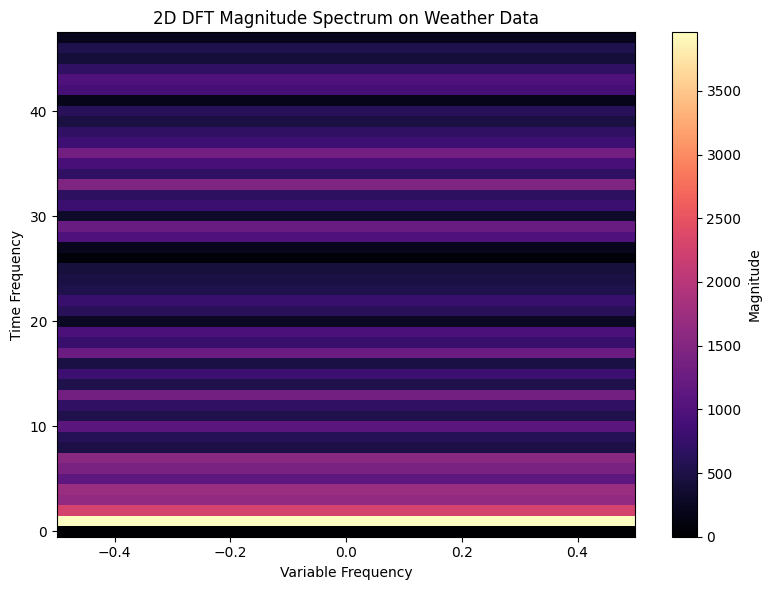

Running 2D FFT on shape: 15 time steps × 7 variables


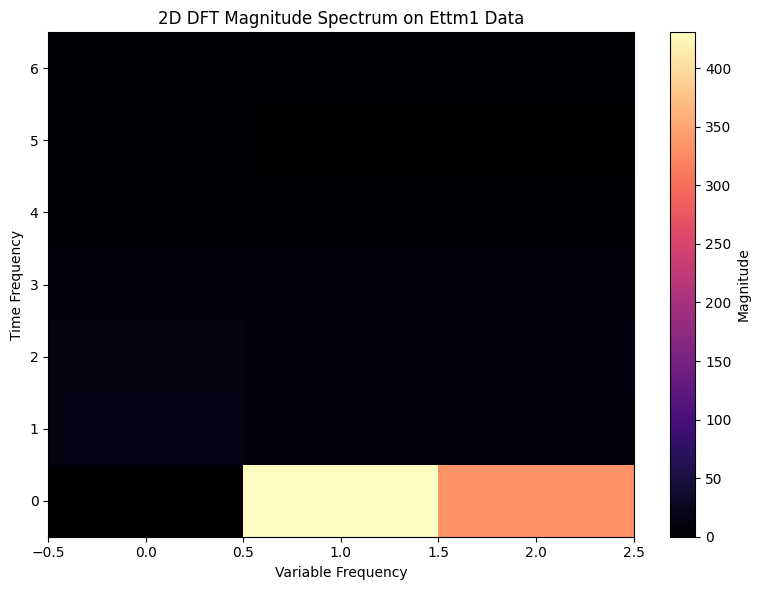

Running 2D FFT on shape: 15 time steps × 321 variables


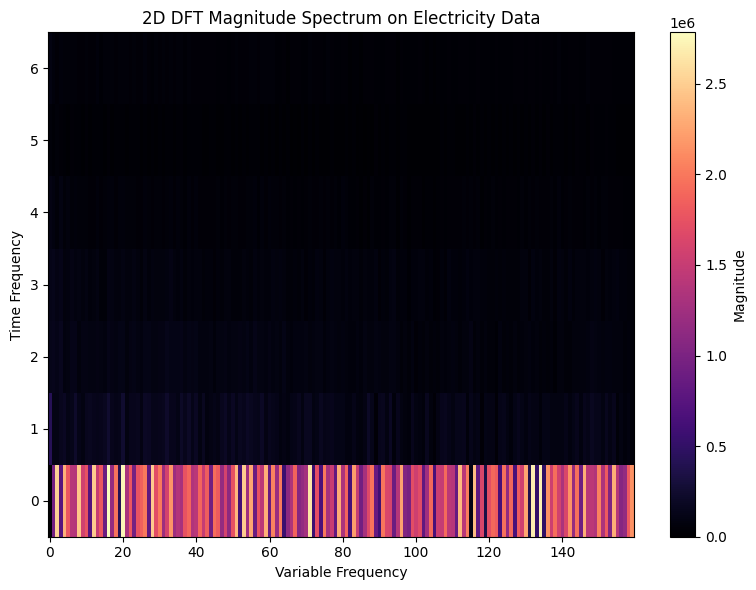

Running 2D FFT on shape: 96 time steps × 8 variables


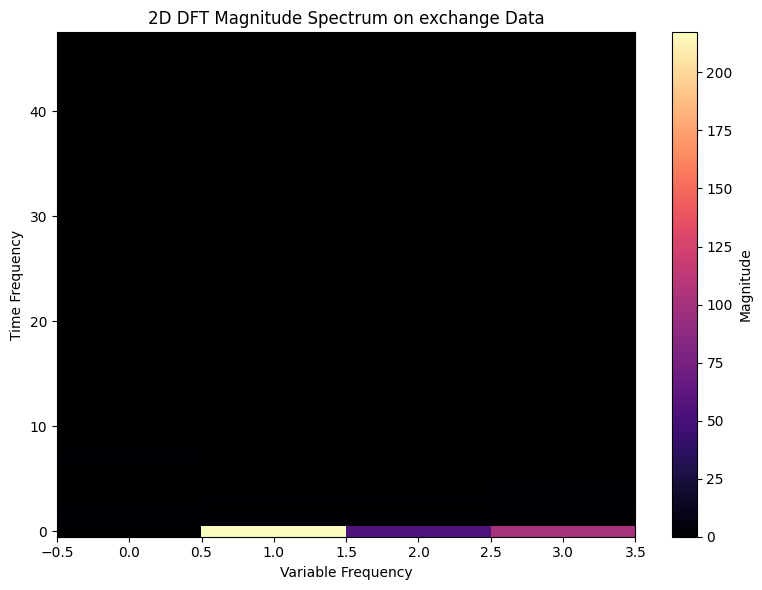

Running 2D FFT on shape: 96 time steps × 862 variables


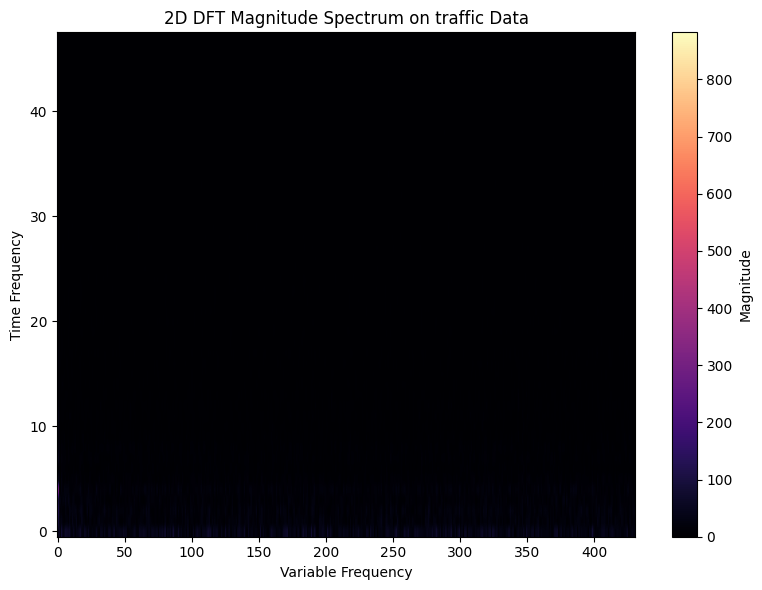

Running 2D FFT on shape: 96 time steps × 12 variables


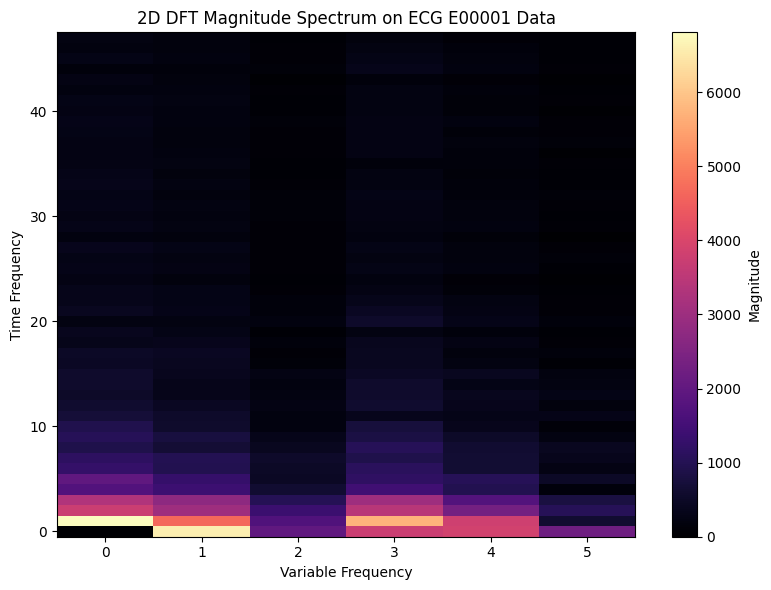

Running 2D FFT on shape: 25 time steps × 36 variables


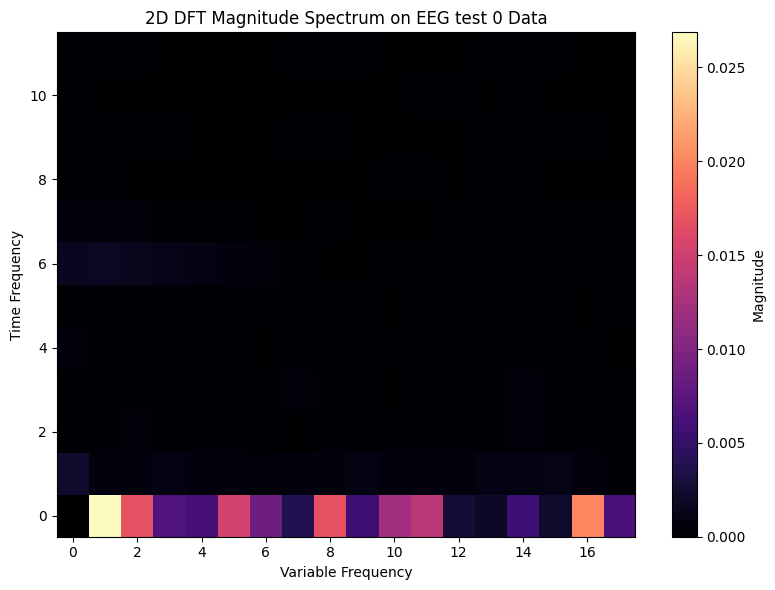

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_2d_dft(timeseries, title='2D Fourier Spectrum'):
    """
    Apply 2D FFT across time and variable dimensions and plot the magnitude spectrum.

    Parameters:
        timeseries (ndarray): A 2D numpy array of shape (T, V), where
                              T = time steps (e.g., 700),
                              V = variables (e.g., electricity substations).
        title (str): Plot title.
    """
    assert timeseries.ndim == 2, "Input must be a 2D array (time × variables)"
    T, V = timeseries.shape
    print(f"Running 2D FFT on shape: {T} time steps × {V} variables")

    # Remove mean across time and variables (detrend)
    X = timeseries - np.mean(timeseries)

    # Apply 2D FFT
    fft2d = np.fft.fft2(X)
    magnitude = np.abs(fft2d)

    # Only plot the low-frequency quadrant (top-left)
    freq_mag = magnitude[:T//2, :V//2]

    plt.figure(figsize=(8, 6))
    plt.imshow(freq_mag, aspect='auto', origin='lower', cmap='magma')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Variable Frequency')
    plt.ylabel('Time Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.show()


df = pd.read_csv(f'/home/../multiTS/NFT/data/noaa/AEM00041217.csv')
X = df.iloc[:96].values
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on Weather Data')


df = pd.read_pickle(f'/home/../multiTS/NFT/data/ettm1/ETTm1_no_date.pkl')
X = df.iloc[:15].values
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on Ettm1 Data')


df = pd.read_pickle(f'/home/../multiTS/NFT/data/electricity/electricity_no_date.pkl')
X = df.iloc[:15].values
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on Electricity Data')


df = pd.read_pickle(f'/home/../multiTS/NFT/data/exchange/exchange_no_date.pkl')
X = df.iloc[:96].values 
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on exchange Data')

df = pd.read_pickle(f'/home/../multiTS/NFT/data/traffic/traffic_no_date.pkl')
X = df.iloc[:96].values 
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on traffic Data')


df = pd.read_pickle('/home/../multiTS/NFT/data/ecg_single/pkl_files/E00001.pkl')
X = df.iloc[:96].values 
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on ECG E00001 Data')



df = pd.read_pickle('/home/../multiTS/NFT/data/eeg_single/test_0.pkl')
X = df.iloc[:25].values 
plot_2d_dft(X, title='2D DFT Magnitude Spectrum on EEG test 0 Data')
